# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [65]:
from statsmodels.tsa.base.prediction import PredictionResults
from sklearn.metrics import mean_absolute_error, median_absolute_error
from matplotlib import pyplot as plt

# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=10.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    print("KPSS={}".format(kpss_stat))# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    diff_ = (y - y_pred)
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': diff_.abs().max(),
        'MIN_ABS': diff_.abs().min()}


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

def model_accuracy(model_creator, data: Series, n_splits: int = 5, test_size: int = 4, plot: bool = False):
    # n_splits x train/test sets with test_size x test oberservations each
    for y_train_idx, y_test_idx in TimeSeriesSplit(n_splits=n_splits, test_size=test_size).split(data):

        y_train = data.iloc[y_train_idx]
        y_test  = data.iloc[y_test_idx]

        predictor: ARIMA = model_creator(y_train)

        model_fit: ARIMAResults = predictor.fit(disp=False)
        forecast_result: PredictionResults = model_fit.get_forecast(steps=test_size)
        # equivalent with model_fit.forecast(steps=test_size)
        y_pred = forecast_result.predicted_mean

        # accuracy
        print(errors(y_test, y_pred))
        # prediction interval: means 95% of all residual errors are equivalent to the lower and upper bounds [mean_ci_lower, mean_ci_upper] so the REAL value could be within these bounds  see [here](https://otexts.com/fpp3/prediction-intervals.html)
        print(forecast_result.summary_frame(alpha=0.05))  #prediction intervals

        if plot:
            f, axes = plt.subplots(1, 1)
            f.set_size_inches(w=20, h=10)
            f = lineplot(data={'train+test': data.iloc[y_test_idx[0]-20:y_test_idx[0]+test_size], 'forecast': y_pred}, markers=True, axes=axes)
            plt.show()

# Preprocessing
Feature engineering, create categorial columns

In [66]:
import pandas as pd
from pandas import DataFrame, DatetimeIndex

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def get_time_series():
    df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

    # get only one store
    df_store_x = df_train.groupby(by='Store').get_group(2)
    df_store_x.index = DatetimeIndex(data=df_store_x['Date'], freq='-1D')
    df_store_x = df_store_x.sort_index()

    # FEATURE ENGINEERING
    ## StateHoliday -> categorial
    df_store_x['StateHoliday'] = df_store_x['StateHoliday'].astype('category')

    ## StateHoliday -> categorial
    df_store_x['DayOfWeek'] = df_store_x['DayOfWeek'].astype('category')

    # drop sundays
    df_store_x = df_store_x[df_store_x['DayOfWeek'] != 7]

    print(df_store_x.info())
    print(df_store_x.head(10))

    y_ = df_store_x['Sales'].asfreq('D', method='ffill') # fill sundays with last valid sales value before
    # y_ = y_.asfreq(pd.offsets.Day)
    # y_ = y_.drop(y_[y_ == 0].index)

    print(y_.head(10))

    return y_

y_t = get_time_series()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 808 entries, 2013-01-01 to 2015-07-31
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          808 non-null    int64         
 1   DayOfWeek      808 non-null    category      
 2   Date           808 non-null    datetime64[ns]
 3   Sales          808 non-null    int64         
 4   Customers      808 non-null    int64         
 5   Open           808 non-null    bool          
 6   Promo          808 non-null    bool          
 7   StateHoliday   808 non-null    category      
 8   SchoolHoliday  808 non-null    bool          
dtypes: bool(3), category(2), datetime64[ns](1), int64(3)
memory usage: 36.1 KB
None
            Store DayOfWeek       Date  Sales  Customers   Open  Promo  \
Date                                                                     
2013-01-01      2         2 2013-01-01      0          0  False  False   
2013-01-0

# Forecast | Analysis
The series is not stationary (mean and variance changes) so lets see whether we can use the differenced series for auto regression and see auto-correlations

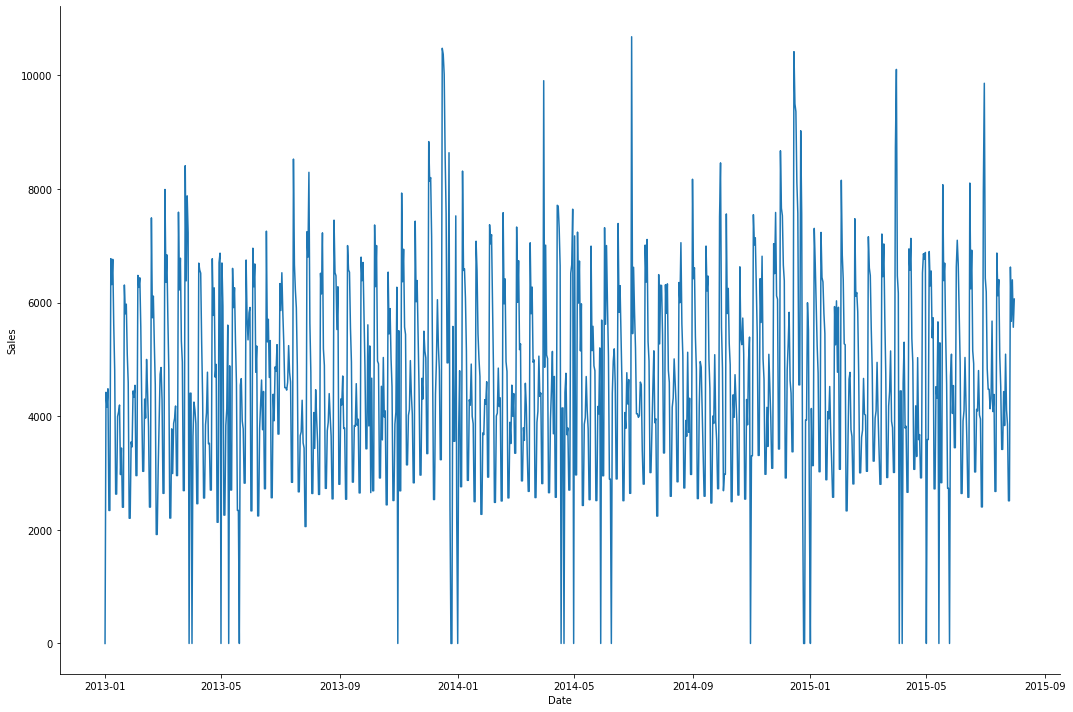

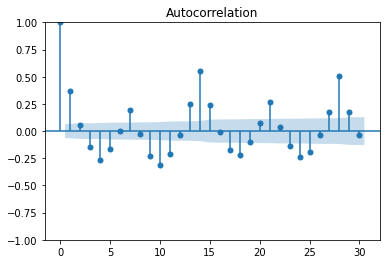

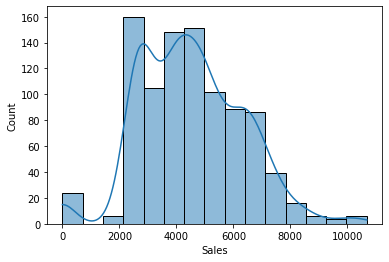

count      942.000000
mean      4531.692144
std       1805.664729
min          0.000000
25%       3021.000000
50%       4408.000000
75%       5804.500000
max      10682.000000
Name: Sales, dtype: float64
KPSS=(0.38213214063018547, 0.08485683593526488, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7fc5484e5340>)


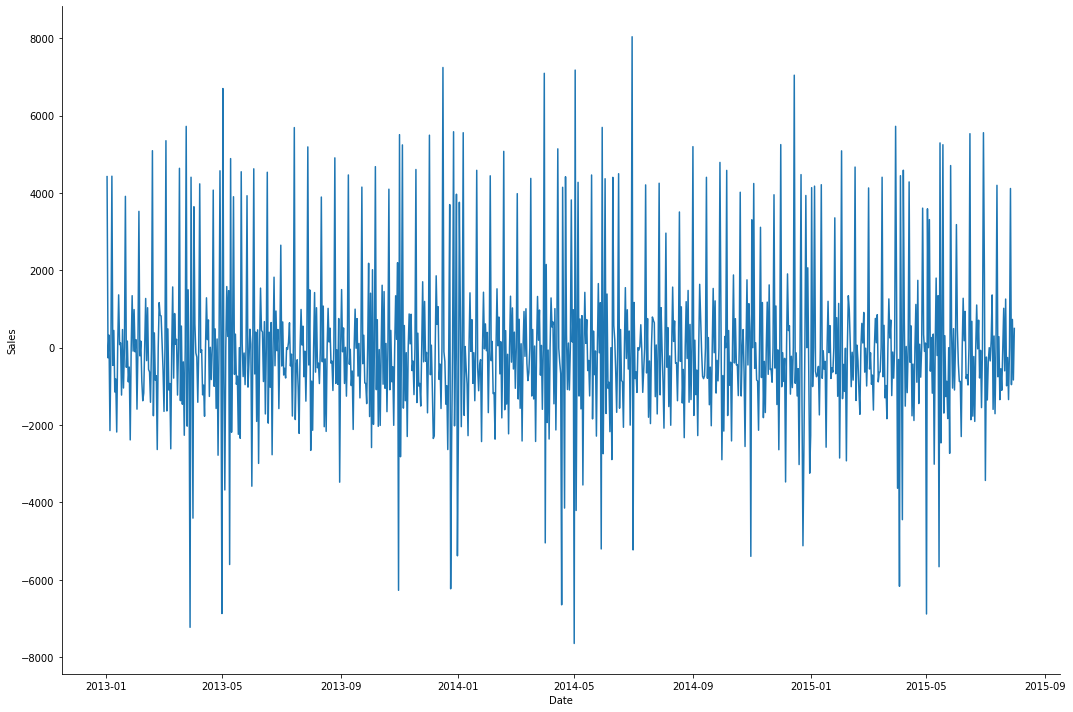

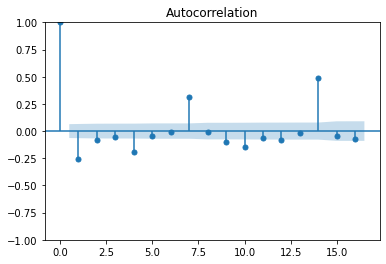

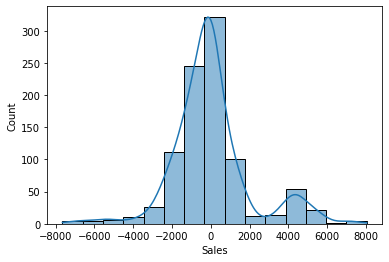

count     941.000000
mean        6.444208
std      2029.395731
min     -7646.000000
25%      -985.000000
50%       -13.000000
75%       556.000000
max      8038.000000
Name: Sales, dtype: float64
KPSS=(0.08587802096493861, 0.1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7fc54874eca0>)


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


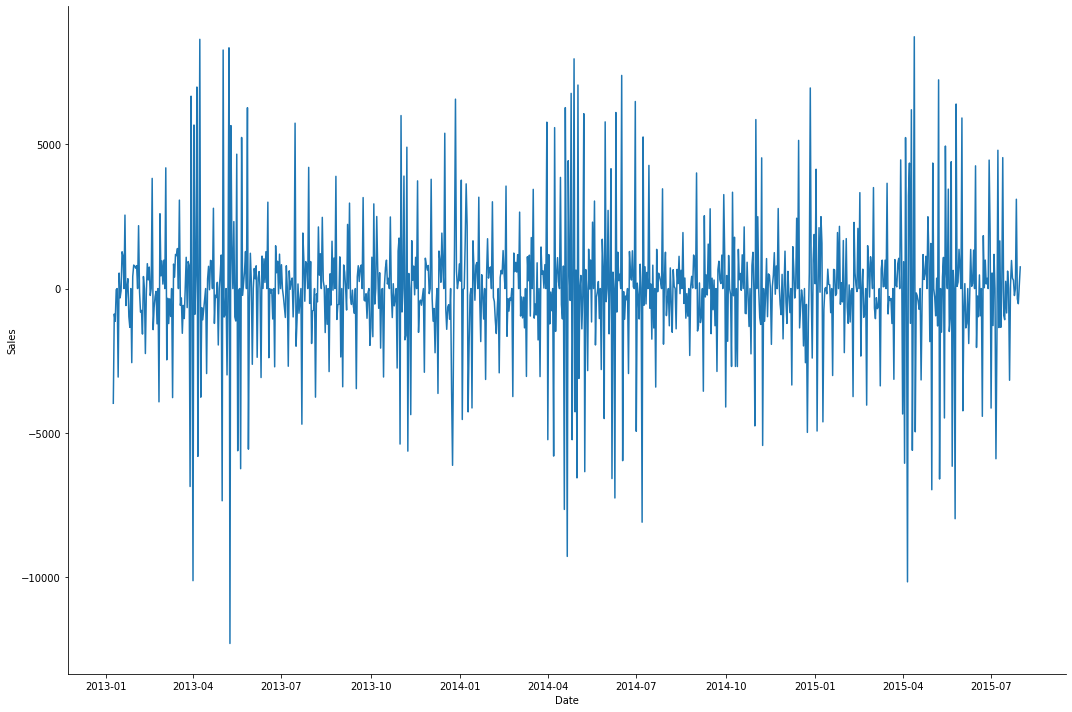

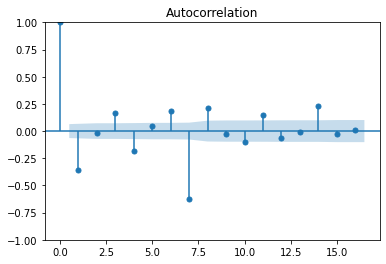

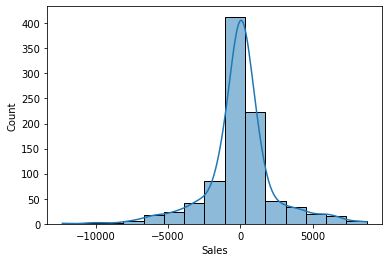

count      934.000000
mean        -4.398287
std       2366.016044
min     -12304.000000
25%       -809.500000
50%          0.000000
75%        794.250000
max       8731.000000
Name: Sales, dtype: float64
KPSS=(0.08767638995926307, 0.1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7fc54889caf0>)


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [67]:
from statsmodels.tsa.statespace.tools import diff

plot_series_hist_acf_kpss(y_t, lags=30)

y_t_diff = diff(series=y_t, k_diff=1)
plot_series_hist_acf_kpss(y_t_diff, lags=16)

y_t_diff = diff(series=y_t, k_seasonal_diff=1, seasonal_periods=7)
plot_series_hist_acf_kpss(y_t_diff, lags=16)

## Forecast | Random walk
If differenced model is white noise (means is stationary, no positive auto correletions, normal distributed diffs with constant variance and mean which is near zero) it is best to use random walk with trend cause it will no get better than using last observation added with average trend of the whole past.

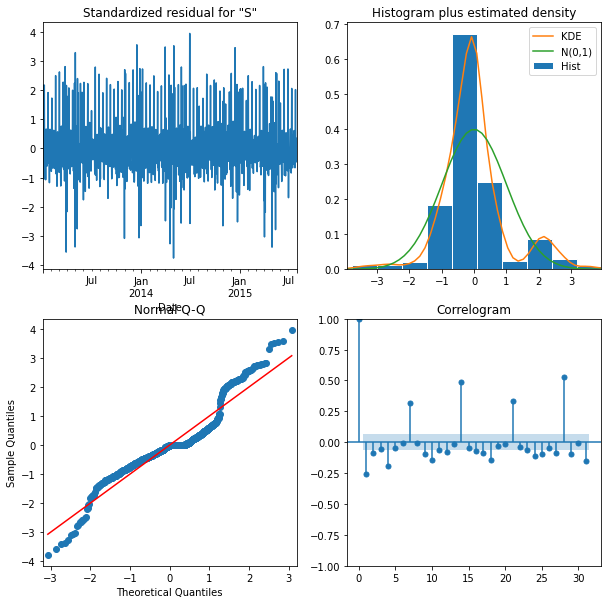

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  942
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8500.900
Date:                Sat, 27 Nov 2021   AIC                          17005.800
Time:                        08:24:42   BIC                          17015.494
Sample:                    01-01-2013   HQIC                         17009.495
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.4442     69.565      0.093      0.926    -129.901     142.790
sigma2      4.114e+06   1.34e+05     30.614      0.000    3.85e+06    4.38e+06
===================================================================================
Ljung-Box (L1) (Q):                  60.98   Jarque-Bera (JB):               294.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.65
Prob(H) (two-sided):                  0.93   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

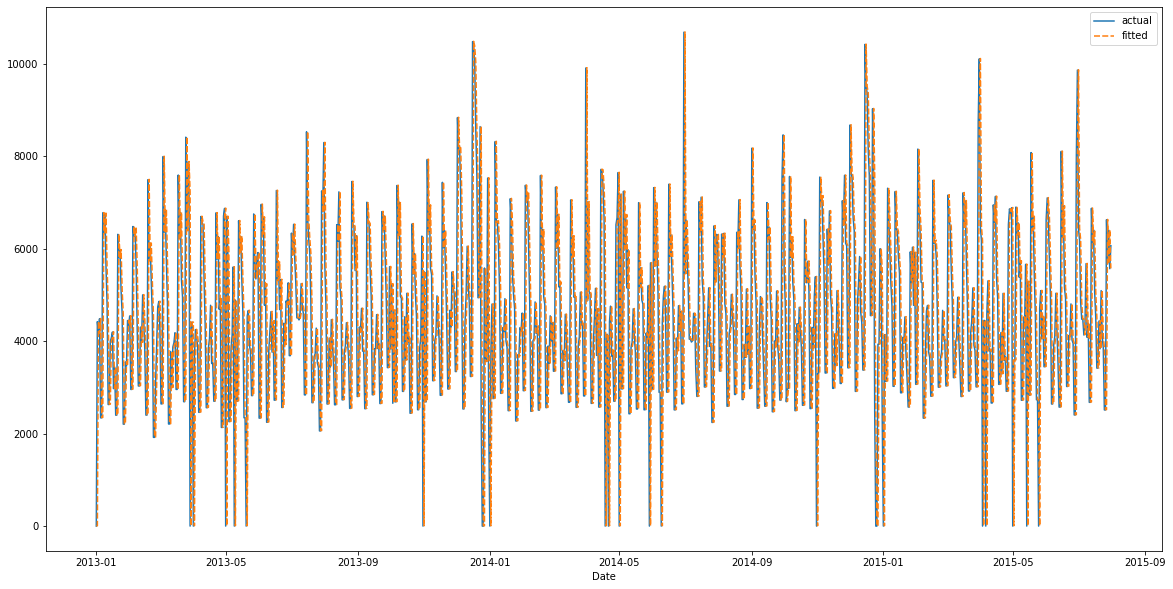

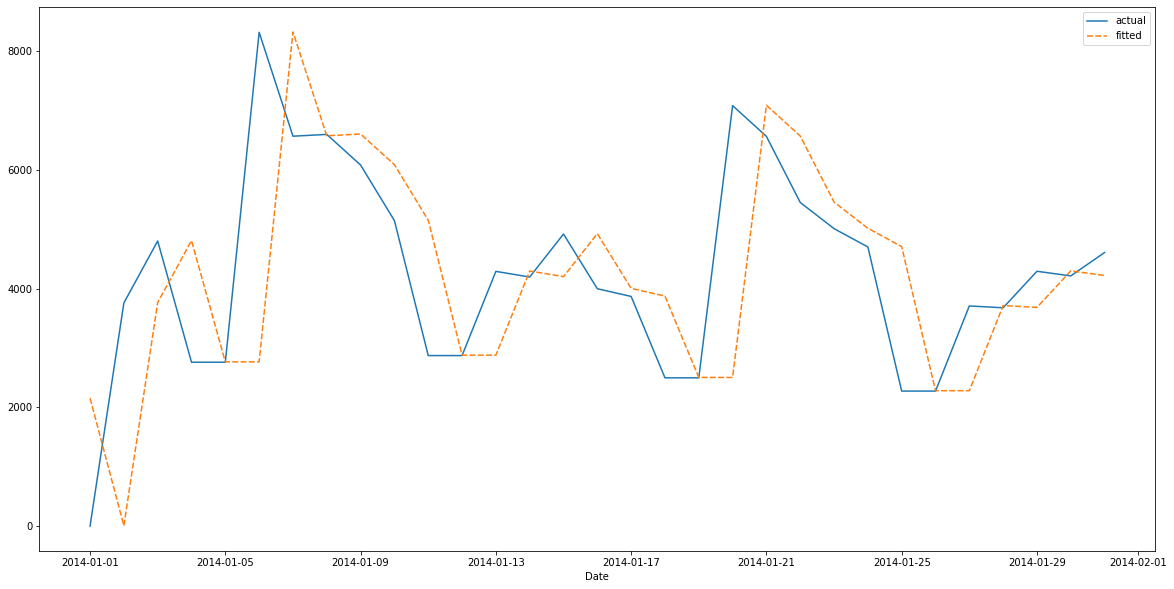

{'RMSE': 2027.2402490677548,
 'MAPE': 4.7791539960234035e+17,
 'MAE': 1327.5259977753258,
 'MEDIAN_AE': 835.9442082890544,
 'MAX_ABS': 8031.555791710945,
 'MIN_ABS': 2.5557917109463233}

{'RMSE': 1853.2568504074452, 'MAPE': 0.3872477516130581, 'MAE': 1718.7074643249168, 'MEDIAN_AE': 1980.7074643249166, 'MAX_ABS': 2334.2963776070237, 'MIN_ABS': 249.05927552140474}
Sales              mean      mean_se  mean_ci_lower  mean_ci_upper
2015-07-02  6438.059276  2046.402485    2427.184108   10448.934443
2015-07-03  6445.118551  2894.050148     772.884492   12117.352610
2015-07-04  6452.177827  3544.473076    -494.861747   13399.217400
2015-07-05  6459.237102  4092.804969   -1562.513234   14480.987438
2015-07-06  6466.296378  4575.895065   -2502.293147   15434.885902
2015-07-07  6473.355653  5012.641896   -3351.241930   16297.953236
{'RMSE': 1517.3100545684774, 'MAPE': 0.31961843178073307, 'MAE': 1250.4505634314794, 'MEDIAN_AE': 1506.5550708833152, 'MAX_ABS': 2532.779716466739, 'MIN_ABS': 56.88985823336952}
Sales              mean      mean_se  mean_ci_lower  mean_ci_upper
2015-07-08  4317.703381  2040.282249     318.823655    8316.583106
2015-07-09  4322.406761  2885.394827   -

In [68]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_creator = lambda y: SARIMAX(endog=y, order=(0, 1, 0), trend='c')
model_fit: ARIMAResults = model_creator(y_t).fit(disp=False)

f = model_fit.plot_diagnostics(lags=31, figsize=(10, 10))
plt.show()

model_fit.summary()

plot_actual_and_fitted_values(y_t, model_fit)

# Let us zoom into it to see the random walk
plot_actual_and_fitted_values(y_t['2014-01-01':'2014-01-31'], model_fit)

model_errors(y_t, model_fit)

# Multi-step forecast: Forecast 5 x 6 day
model_accuracy(model_creator, data=y_t, n_splits=5, test_size=6)

# Forecast 8 x 1 day
model_accuracy(model_creator, data=y_t, n_splits=8, test_size=1)


## Forecast | Seasonal

Forecast with seasonal on nonseasonal differenced

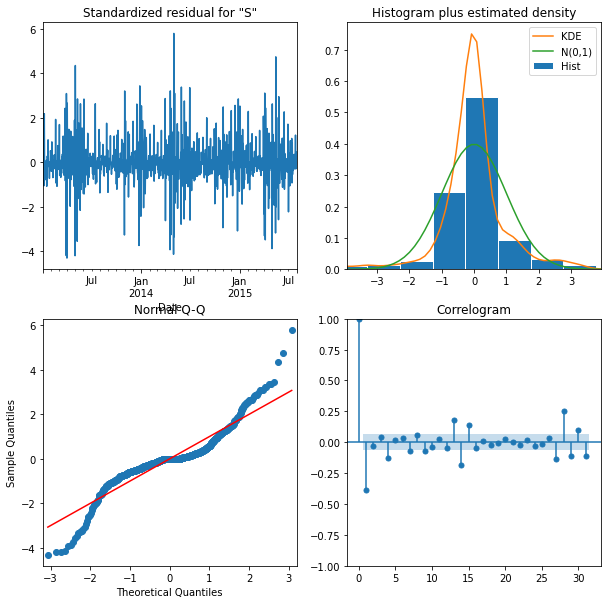

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  942
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 7)   Log Likelihood               -8353.531
Date:                           Sat, 27 Nov 2021   AIC                          16715.062
Time:                                   08:24:45   BIC                          16734.450
Sample:                               01-01-2013   HQIC                         16722.452
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.4878     56.704      0.114      0.909    -104.650     117.626
ar.S.L7        0.1823      0.024      7.700      0.000       0.136       0.229
ar.S.L14       0.4324      0.019     22.753      0.000       0.395       0.470
sigma2      2.997e+06   7.65e+04     39.184      0.000    2.85e+06    3.15e+06
===================================================================================
Ljung-Box (L1) (Q):                 140.10   Jarque-Bera (JB):              1134.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.18
Prob(H) (two-sided):                  0.29   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

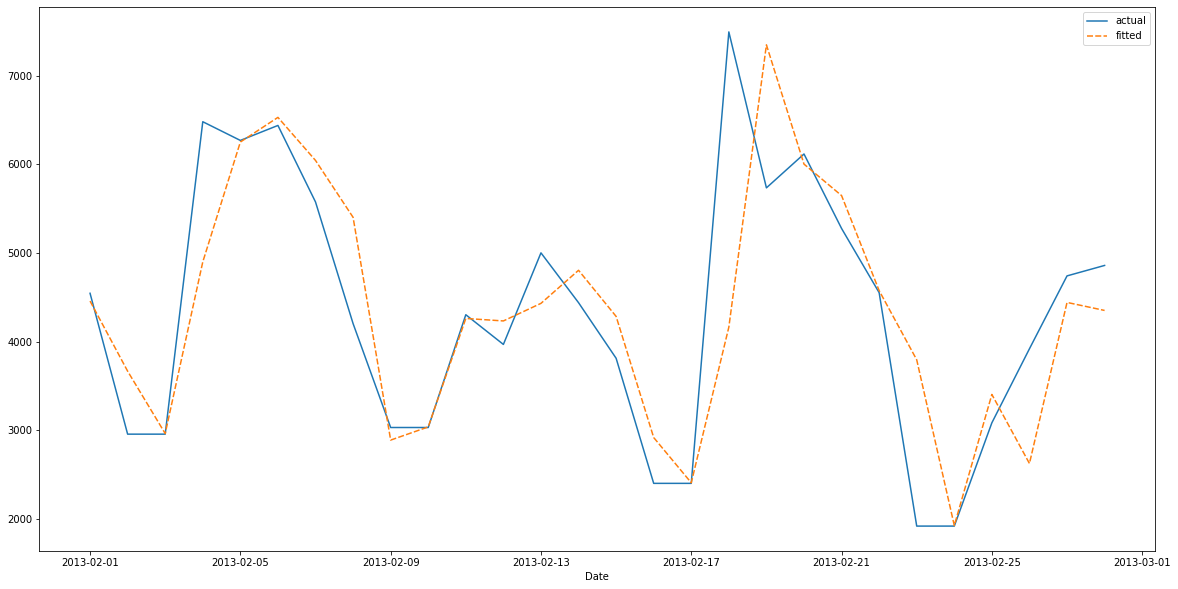

{'RMSE': 1734.1709961181077,
 'MAPE': 5.171447688728258e+17,
 'MAE': 1041.1780361771455,
 'MEDIAN_AE': 531.0809673090248,
 'MAX_ABS': 10021.621733163061,
 'MIN_ABS': 2.0004485980812206}

Multi-step forecast: Forecast n x M days
{'RMSE': 1497.7325021264478, 'MAPE': 0.16046723100165755, 'MAE': 1060.708511382695, 'MEDIAN_AE': 1060.708511382695, 'MAX_ABS': 2118.1110372952526, 'MIN_ABS': 3.3059854701373297}
Sales              mean      mean_se  mean_ci_lower  mean_ci_upper
2015-07-26  2515.305985  1735.087492    -885.403008    5916.014979
2015-07-27  4508.888963  2453.784263    -300.439818    9318.217744


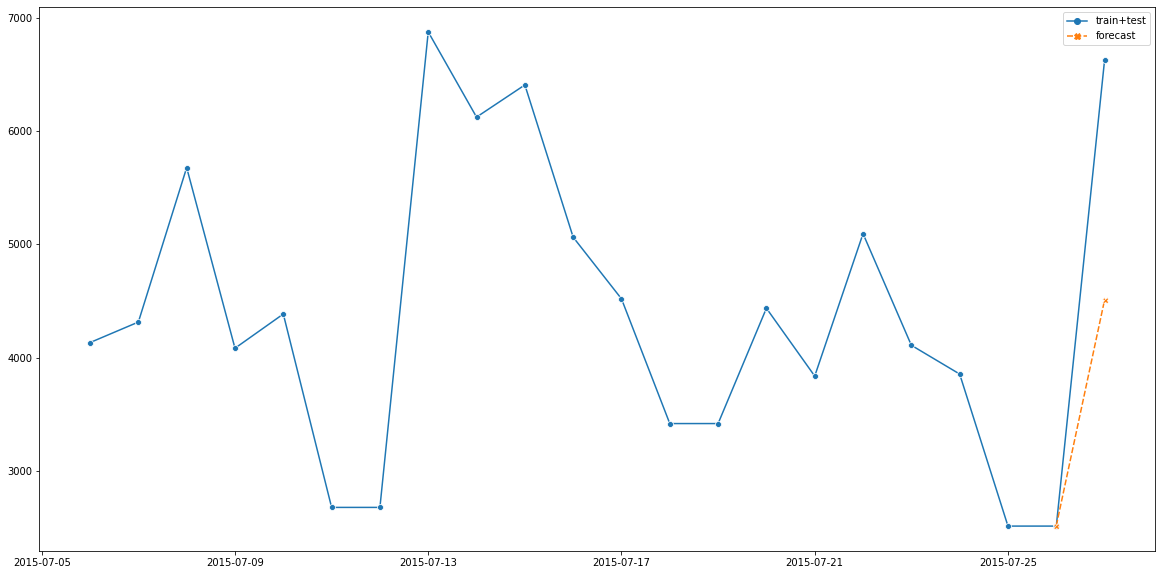

{'RMSE': 389.354175012222, 'MAPE': 0.05871132572685877, 'MAE': 341.82410437509725, 'MEDIAN_AE': 341.82410437509725, 'MAX_ABS': 528.245549674748, 'MIN_ABS': 155.40265907544654}
Sales              mean      mean_se  mean_ci_lower  mean_ci_upper
2015-07-28  6199.245550  1734.574316    2799.542362    9598.948738
2015-07-29  6557.402659  2453.058523    1749.496302   11365.309016


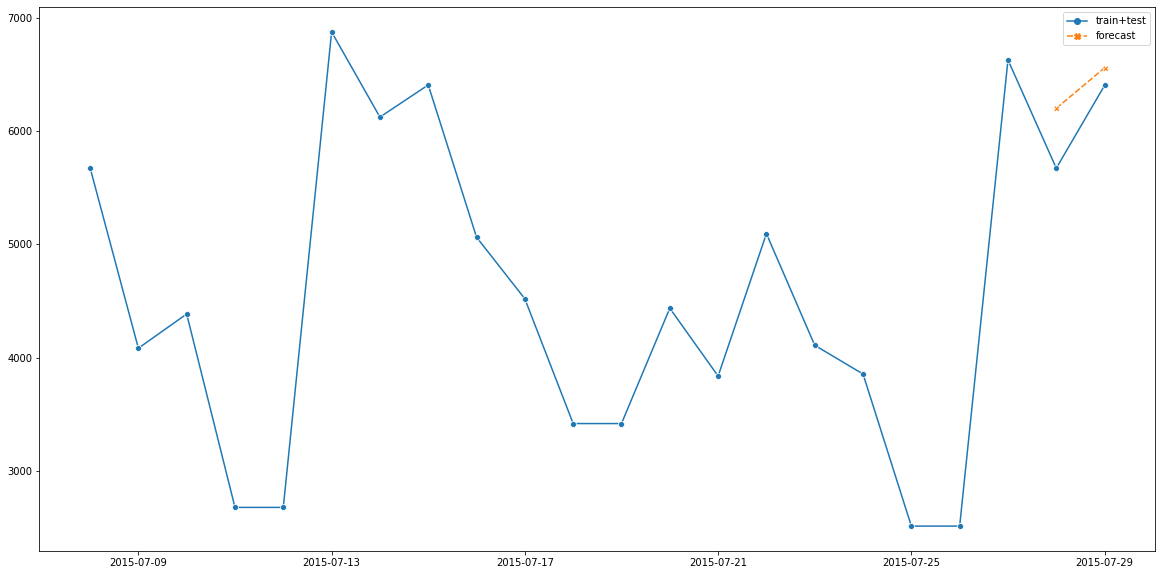

{'RMSE': 492.46808735254524, 'MAPE': 0.06427094662047454, 'MAE': 386.14546398048424, 'MEDIAN_AE': 386.14546398048424, 'MAX_ABS': 691.7865896621743, 'MIN_ABS': 80.50433829879421}
Sales              mean      mean_se  mean_ci_lower  mean_ci_upper
2015-07-30  5647.504338  1732.851685    2251.177444    9043.831232
2015-07-31  5372.213410  2450.622355     569.081855   10175.344966


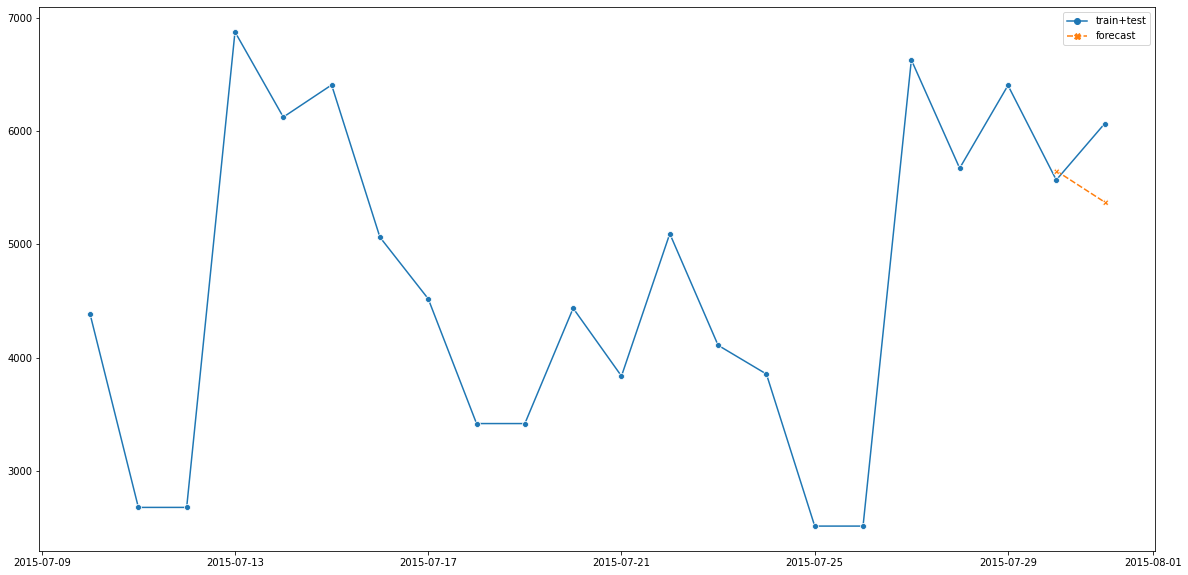

 Forecast 8 x 1 day 


In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_creator = lambda y: SARIMAX(endog=y, order=(0, 1, 0), seasonal_order=(2, 0, 0, 7), trend='c')

model_fit: ARIMAResults = model_creator(y_t).fit(disp=False)

f = model_fit.plot_diagnostics(lags=31, figsize=(10, 10))
plt.show()

model_fit.summary()

# Let us zoom into it to see the random walk
plot_actual_and_fitted_values(y_t['2013-02-01':'2013-02-28'], model_fit)

model_errors(y_t, model_fit)

print('Multi-step forecast: Forecast n x M days')
model_accuracy(model_creator, data=y_t, n_splits=3, test_size=2, plot=True)

print(' Forecast 8 x 1 day ')
#model_accuracy(model_creator, data=y_t, n_splits=7, test_size=1)


